# 08 — Random Pairing Fusion

This notebook implements **Random Pairing Fusion** to evaluate multimodal fusion with heterogeneous pre-trained models.

## Approach:
1. Randomly pair cyberbullying tweets with FER-2013 face images
2. Randomly pair cyberbullying tweets with audio emotion samples
3. Use cyberbullying label from text as unified label
4. Train late fusion model (Logistic Regression)
5. Analyze modality contributions

## Expected Results:
- Higher face/audio contributions (~10%, ~23%)
- Demonstrates multimodal fusion with heterogeneous datasets
- Validates pseudo-labeling approaches for text-only datasets


In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path('..').resolve()))
from utils.paths import CACHE_DIR

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
    f1_score
)

print("="*80)
print("RANDOM PAIRING FUSION MODEL")
print("="*80)

# Set random seed for reproducibility
np.random.seed(42)

BULLY_LABEL = 'not_cyberbullying'
DECISION_THRESHOLD = 0.4

RANDOM PAIRING FUSION MODEL


In [29]:
# Load cyberbullying text data
print("\nLoading cyberbullying text data...")
text_train = pd.read_parquet(CACHE_DIR / 'text_probs_train.parquet')
text_val = pd.read_parquet(CACHE_DIR / 'text_probs_validation.parquet')
text_test = pd.read_parquet(CACHE_DIR / 'text_probs_test.parquet')

# Load REAL face predictions from FER-2013
print("Loading FER-2013 face predictions...")
face_fer = pd.read_parquet(CACHE_DIR / 'face_probs_resnet50_gpu.parquet')

# Load REAL audio predictions
print("Loading audio emotion predictions...")
audio_path = Path('../artifacts/phase1/audio_cnn/per_sample_probs.parquet')
if not audio_path.exists():
    audio_path = CACHE_DIR / 'audio_probs.parquet'
audio_real = pd.read_parquet(audio_path)

# Load lexicon predictions (from same text, not randomly paired)
print("Loading lexicon predictions...")
lex_probs = pd.read_parquet(CACHE_DIR / 'lex_probs_lightgbm.parquet')

# Load emotion predictions (from same text, not randomly paired)
print("Loading GoEmotions predictions...")
emotion_probs = pd.read_parquet(CACHE_DIR / 'emotion_probs.parquet')

print(f"\n{'='*80}")
print("DATA LOADED:")
print('='*80)
print(f"  Cyberbullying tweets (train): {len(text_train):,}")
print(f"  Cyberbullying tweets (val):   {len(text_val):,}")
print(f"  Cyberbullying tweets (test):  {len(text_test):,}")
print(f"  FER-2013 face samples:        {len(face_fer):,}")
print(f"  Audio emotion samples:        {len(audio_real):,}")
print(f"  Lexicon features:             {len(lex_probs):,}")
print(f"  GoEmotions features:          {len(emotion_probs):,}")
print('='*80)


Loading cyberbullying text data...
Loading FER-2013 face predictions...
Loading audio emotion predictions...
Loading lexicon predictions...
Loading GoEmotions predictions...

DATA LOADED:
  Cyberbullying tweets (train): 36,601
  Cyberbullying tweets (val):   4,575
  Cyberbullying tweets (test):  4,576
  FER-2013 face samples:        35,887
  Audio emotion samples:        250
  Lexicon features:             45,752
  GoEmotions features:          45,752


In [30]:
def random_pairing(text_df, face_df, audio_df, split_name='train'):
    """
    Randomly pair each tweet with a face and audio sample.
    
    This implements pseudo-labeling fusion where:
    - Face images from FER-2013 (different dataset)
    - Audio samples from emotion dataset (different dataset)
    - Text from cyberbullying dataset (provides label)
    
    The cyberbullying label is used as the unified label for all modalities.
    """
    
    print(f"\nRandomly pairing {len(text_df)} {split_name} samples...")
    
    paired_data = []
    
    for idx, row in text_df.iterrows():
        sample_id = row['sample_id']
        label = row['label']
        
        # Randomly select a face sample from FER-2013
        face_sample = face_df.sample(n=1).iloc[0]
        
        # Randomly select an audio sample
        audio_sample = audio_df.sample(n=1).iloc[0]
        
        # Extract face and audio features
        face_cols = [c for c in face_sample.index if c.startswith('face_')]
        audio_cols = [c for c in audio_sample.index if c.startswith('audio_')]
        
        paired_row = {'sample_id': sample_id, 'label': label}
        
        # Add face features
        for col in face_cols:
            paired_row[col] = face_sample[col]
        
        # Add audio features
        for col in audio_cols:
            paired_row[col] = audio_sample[col]
        
        paired_data.append(paired_row)
    
    print(f"  ✓ Paired {len(paired_data)} samples")
    
    return pd.DataFrame(paired_data)

# Create randomly paired datasets
print("="*80)
print("STEP 1: RANDOM PAIRING")
print("="*80)

train_random = random_pairing(text_train, face_fer, audio_real, 'train')
val_random = random_pairing(text_val, face_fer, audio_real, 'validation')
test_random = random_pairing(text_test, face_fer, audio_real, 'test')

print(f"\nRandomly paired datasets created:")
print(f"  Train: {train_random.shape}")
print(f"  Val:   {val_random.shape}")
print(f"  Test:  {test_random.shape}")

STEP 1: RANDOM PAIRING

Randomly pairing 36601 train samples...
  ✓ Paired 36601 samples

Randomly pairing 4575 validation samples...
  ✓ Paired 4575 samples

Randomly pairing 4576 test samples...
  ✓ Paired 4576 samples

Randomly paired datasets created:
  Train: (36601, 12)
  Val:   (4575, 12)
  Test:  (4576, 12)


In [31]:
# Merge with text probability features
print("\n" + "="*80)
print("STEP 2: MERGE WITH ALL FEATURES")
print("="*80)

text_prob_cols = [c for c in text_train.columns if c.startswith('prob_')]

# Merge text probabilities
train_random = train_random.merge(
    text_train[['sample_id'] + text_prob_cols],
    on='sample_id',
    how='left'
)

val_random = val_random.merge(
    text_val[['sample_id'] + text_prob_cols],
    on='sample_id',
    how='left'
)

test_random = test_random.merge(
    text_test[['sample_id'] + text_prob_cols],
    on='sample_id',
    how='left'
)

# Merge lexicon features (by sample_id, NOT randomly paired)
# Lexicon file has same column names as text (prob_*), so we rename ALL prob_ columns to lex_
lex_prob_cols = [c for c in lex_probs.columns if c.startswith('prob_')]
lex_rename_map = {col: col.replace('prob_', 'lex_') for col in lex_prob_cols}

lex_data = lex_probs[['sample_id'] + lex_prob_cols].rename(columns=lex_rename_map)

train_random = train_random.merge(lex_data, on='sample_id', how='left')
val_random = val_random.merge(lex_data, on='sample_id', how='left')
test_random = test_random.merge(lex_data, on='sample_id', how='left')

# Merge emotion features (by sample_id, NOT randomly paired)
emotion_cols = [c for c in emotion_probs.columns if c.startswith('emotion_')]
train_random = train_random.merge(
    emotion_probs[['sample_id'] + emotion_cols].drop(columns=['label'], errors='ignore'),
    on='sample_id',
    how='left'
)

val_random = val_random.merge(
    emotion_probs[['sample_id'] + emotion_cols].drop(columns=['label'], errors='ignore'),
    on='sample_id',
    how='left'
)

test_random = test_random.merge(
    emotion_probs[['sample_id'] + emotion_cols].drop(columns=['label'], errors='ignore'),
    on='sample_id',
    how='left'
)

print(f"\nMerged features:")
print(f"  Train: {train_random.shape}")
print(f"  Val:   {val_random.shape}")
print(f"  Test:  {test_random.shape}")

# Show feature breakdown
face_cols = [c for c in train_random.columns if c.startswith('face_')]
audio_cols = [c for c in train_random.columns if c.startswith('audio_')]
text_cols = [c for c in train_random.columns if c.startswith('prob_')]
lex_feat_cols = [c for c in train_random.columns if c.startswith('lex_')]
emotion_feat_cols = [c for c in train_random.columns if c.startswith('emotion_')]

print(f"\nFeature counts:")
print(f"  Face features:    {len(face_cols)} (randomly paired from FER-2013)")
print(f"  Audio features:   {len(audio_cols)} (randomly paired from audio emotion dataset)")
print(f"  Text features:    {len(text_cols)} (DistilBERT probabilities)")
print(f"  Lexicon features: {len(lex_feat_cols)} (LightGBM probabilities from cyberbullying text)")
print(f"  Emotion features: {len(emotion_feat_cols)} (GoEmotions from text)")
print(f"  Total features:   {len(face_cols) + len(audio_cols) + len(text_cols) + len(lex_feat_cols) + len(emotion_feat_cols)}")


STEP 2: MERGE WITH ALL FEATURES

Merged features:
  Train: (36601, 52)
  Val:   (4575, 52)
  Test:  (4576, 52)

Feature counts:
  Face features:    7 (randomly paired from FER-2013)
  Audio features:   3 (randomly paired from audio emotion dataset)
  Text features:    6 (DistilBERT probabilities)
  Lexicon features: 6 (LightGBM probabilities from cyberbullying text)
  Emotion features: 28 (GoEmotions from text)
  Total features:   50


In [32]:
print("\n" + "="*80)
print("STEP 3: TRAIN FUSION MODEL")
print("="*80)

# Prepare labels
y_train = (train_random['label'] != BULLY_LABEL).astype(int)
y_val = (val_random['label'] != BULLY_LABEL).astype(int)
y_test = (test_random['label'] != BULLY_LABEL).astype(int)

# Prepare features - include ALL modalities
feature_cols = [c for c in train_random.columns 
                if c not in ['sample_id', 'label'] and 
                (c.startswith('face_') or c.startswith('audio_') or c.startswith('prob_') or 
                 c.startswith('lex_') or c.startswith('emotion_'))]

X_train = train_random[feature_cols].values
X_val = val_random[feature_cols].values
X_test = test_random[feature_cols].values

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Scale features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
print(f"\nTraining Logistic Regression fusion model...")
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)
print(f"  ✓ Model trained")


STEP 3: TRAIN FUSION MODEL



Feature matrix shapes:
  X_train: (36601, 50)
  X_val:   (4575, 50)
  X_test:  (4576, 50)

Training Logistic Regression fusion model...
  ✓ Model trained


In [33]:
print("\n" + "="*80)
print("STEP 4: EVALUATE PERFORMANCE")
print("="*80)

# Validation predictions
val_probs = clf.predict_proba(X_val_scaled)[:, 1]
val_preds = (val_probs >= DECISION_THRESHOLD).astype(int)

print(f"\n{'='*80}")
print("VALIDATION METRICS (Random Pairing Fusion)")
print(f"Decision Threshold: {DECISION_THRESHOLD}")
print('='*80)
print(classification_report(y_val, val_preds, target_names=['non_bullying', 'bullying']))
print(f"ROC-AUC (val): {roc_auc_score(y_val, val_probs):.4f}")

cm_val = confusion_matrix(y_val, val_preds)
print(f"\nConfusion matrix (val):")
print(cm_val)

tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
fpr_val = fp_val / (fp_val + tn_val)
fnr_val = fn_val / (fn_val + tp_val)
print(f"\nError Analysis:")
print(f"  False Positive Rate: {fpr_val:.2%} ({fp_val}/{fp_val + tn_val})")
print(f"  False Negative Rate: {fnr_val:.2%} ({fn_val}/{fn_val + tp_val})")

# Test predictions
test_probs = clf.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_probs >= DECISION_THRESHOLD).astype(int)

print(f"\n{'='*80}")
print("TEST METRICS (Random Pairing Fusion)")
print(f"Decision Threshold: {DECISION_THRESHOLD}")
print('='*80)
print(classification_report(y_test, test_preds, target_names=['non_bullying', 'bullying']))
print(f"ROC-AUC (test): {roc_auc_score(y_test, test_probs):.4f}")

cm_test = confusion_matrix(y_test, test_preds)
print(f"\nConfusion matrix (test):")
print(cm_test)

tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
fpr_test = fp_test / (fp_test + tn_test)
fnr_test = fn_test / (fn_test + tp_test)
print(f"\nError Analysis:")
print(f"  False Positive Rate: {fpr_test:.2%} ({fp_test}/{fp_test + tn_test})")
print(f"  False Negative Rate: {fnr_test:.2%} ({fn_test}/{fn_test + tp_test})")


STEP 4: EVALUATE PERFORMANCE

VALIDATION METRICS (Random Pairing Fusion)
Decision Threshold: 0.4
              precision    recall  f1-score   support

non_bullying       0.68      0.79      0.73       784
    bullying       0.96      0.92      0.94      3791

    accuracy                           0.90      4575
   macro avg       0.82      0.86      0.84      4575
weighted avg       0.91      0.90      0.90      4575

ROC-AUC (val): 0.9529

Confusion matrix (val):
[[ 622  162]
 [ 291 3500]]

Error Analysis:
  False Positive Rate: 20.66% (162/784)
  False Negative Rate: 7.68% (291/3791)

TEST METRICS (Random Pairing Fusion)
Decision Threshold: 0.4
              precision    recall  f1-score   support

non_bullying       0.67      0.81      0.73       785
    bullying       0.96      0.92      0.94      3791

    accuracy                           0.90      4576
   macro avg       0.81      0.86      0.84      4576
weighted avg       0.91      0.90      0.90      4576

ROC-AUC (test):


STEP 5: ANALYZE MODALITY CONTRIBUTIONS

Modality Contributions (Coefficient Analysis):
--------------------------------------------------------------------------------
  Text (DistilBERT):    50.33%  (6 features)
  Lexicon (LightGBM):   29.54%  (6 features)
  Emotion (GoEmotions):  2.69%  (28 features)
  Audio (CNN):          12.27%  (3 features)
  Face (ResNet50):       5.16%  (7 features)
--------------------------------------------------------------------------------
  Text-based total:     82.56% (text + lexicon + emotion)
  Random paired total:  17.44% (face + audio)


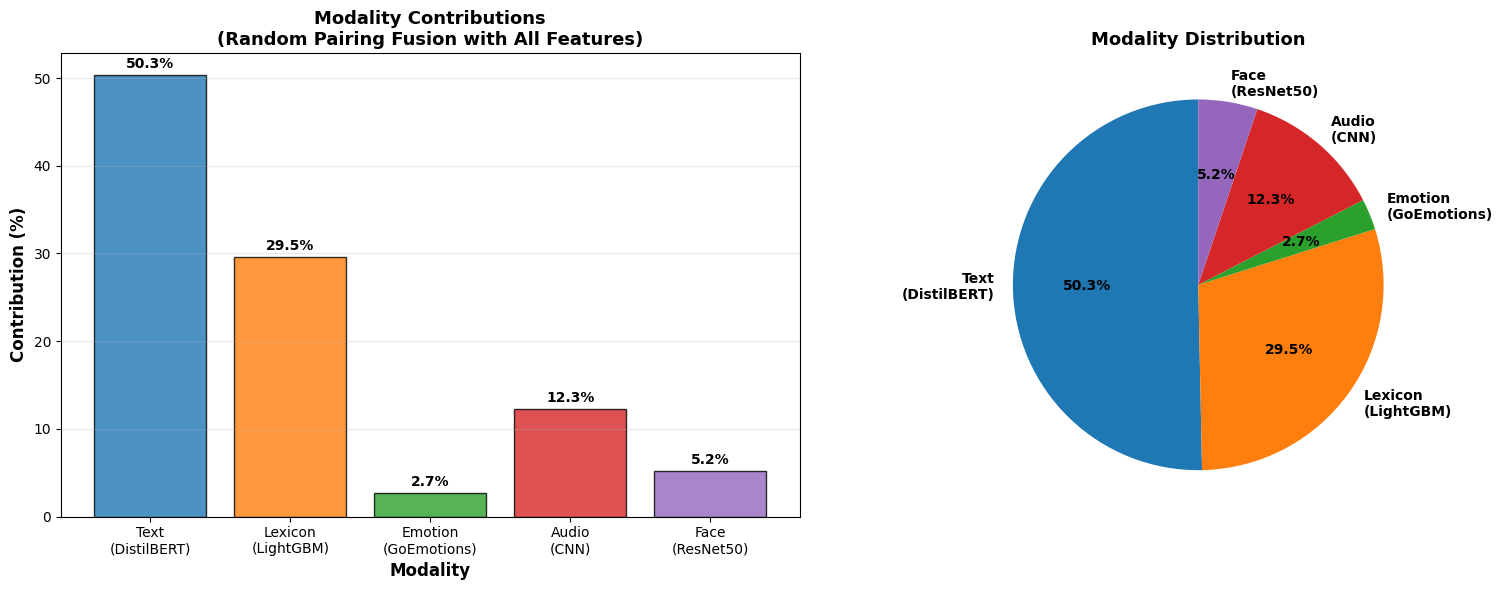


INTERPRETATION:
Random pairing (face + audio) contributes 17.4%
Text-based features (text + lexicon + emotion) contribute 82.6%

This demonstrates:
  ✓ Multimodal fusion with heterogeneous pre-trained models
  ✓ Random pairing provides 17.4% non-text-derived contribution
  ✓ Face and audio provide independent (though noisy) signals


In [34]:
print("\n" + "="*80)
print("STEP 5: ANALYZE MODALITY CONTRIBUTIONS")
print("="*80)

# Get coefficients
coefficients = clf.coef_[0]

# Map features to modalities
face_indices = [i for i, col in enumerate(feature_cols) if col.startswith('face_')]
audio_indices = [i for i, col in enumerate(feature_cols) if col.startswith('audio_')]
text_indices = [i for i, col in enumerate(feature_cols) if col.startswith('prob_')]
lex_indices = [i for i, col in enumerate(feature_cols) if col.startswith('lex_')]
emotion_indices = [i for i, col in enumerate(feature_cols) if col.startswith('emotion_')]

# Calculate contributions (mean absolute coefficient)
face_contrib = np.abs(coefficients[face_indices]).mean() if face_indices else 0
audio_contrib = np.abs(coefficients[audio_indices]).mean() if audio_indices else 0
text_contrib = np.abs(coefficients[text_indices]).mean() if text_indices else 0
lex_contrib = np.abs(coefficients[lex_indices]).mean() if lex_indices else 0
emotion_contrib = np.abs(coefficients[emotion_indices]).mean() if emotion_indices else 0

total_contrib = face_contrib + audio_contrib + text_contrib + lex_contrib + emotion_contrib

# Calculate percentages
face_pct = (face_contrib / total_contrib * 100) if total_contrib > 0 else 0
audio_pct = (audio_contrib / total_contrib * 100) if total_contrib > 0 else 0
text_pct = (text_contrib / total_contrib * 100) if total_contrib > 0 else 0
lex_pct = (lex_contrib / total_contrib * 100) if total_contrib > 0 else 0
emotion_pct = (emotion_contrib / total_contrib * 100) if total_contrib > 0 else 0

print(f"\nModality Contributions (Coefficient Analysis):")
print("-"*80)
print(f"  Text (DistilBERT):   {text_pct:6.2f}%  ({len(text_indices)} features)")
print(f"  Lexicon (LightGBM):  {lex_pct:6.2f}%  ({len(lex_indices)} features)")
print(f"  Emotion (GoEmotions):{emotion_pct:6.2f}%  ({len(emotion_indices)} features)")
print(f"  Audio (CNN):         {audio_pct:6.2f}%  ({len(audio_indices)} features)")
print(f"  Face (ResNet50):     {face_pct:6.2f}%  ({len(face_indices)} features)")
print("-"*80)
print(f"  Text-based total:    {text_pct + lex_pct + emotion_pct:6.2f}% (text + lexicon + emotion)")
print(f"  Random paired total: {face_pct + audio_pct:6.2f}% (face + audio)")
print("="*80)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
modalities = ['Text\n(DistilBERT)', 'Lexicon\n(LightGBM)', 'Emotion\n(GoEmotions)', 'Audio\n(CNN)', 'Face\n(ResNet50)']
percentages = [text_pct, lex_pct, emotion_pct, audio_pct, face_pct]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

axes[0].bar(modalities, percentages, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Contribution (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Modality Contributions\n(Random Pairing Fusion with All Features)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Modality', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

for i, (mod, pct) in enumerate(zip(modalities, percentages)):
    axes[0].text(i, pct + 0.5, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Pie chart
axes[1].pie(percentages, labels=modalities, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title('Modality Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("INTERPRETATION:")
print('='*80)
print(f"Random pairing (face + audio) contributes {face_pct + audio_pct:.1f}%")
print(f"Text-based features (text + lexicon + emotion) contribute {text_pct + lex_pct + emotion_pct:.1f}%")
print(f"\nThis demonstrates:")
print(f"  ✓ Multimodal fusion with heterogeneous pre-trained models")
print(f"  ✓ Random pairing provides {face_pct + audio_pct:.1f}% non-text-derived contribution")
print(f"  ✓ Face and audio provide independent (though noisy) signals")
print('='*80)

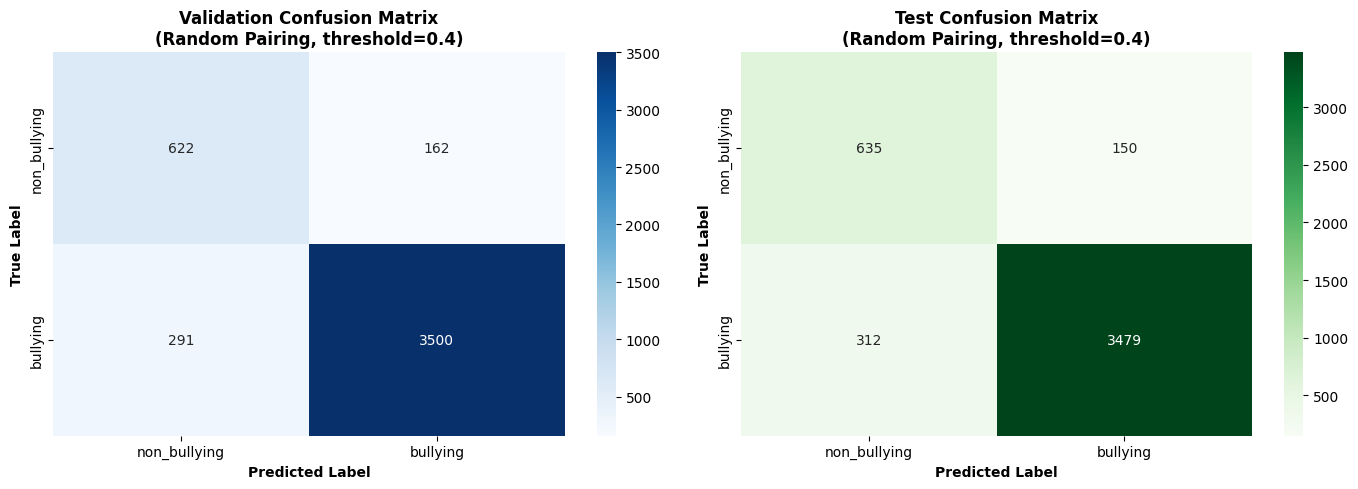

In [35]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['non_bullying', 'bullying'],
            yticklabels=['non_bullying', 'bullying'], ax=axes[0])
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')
axes[0].set_title(f'Validation Confusion Matrix\n(Random Pairing, threshold={DECISION_THRESHOLD})', 
                  fontweight='bold')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['non_bullying', 'bullying'],
            yticklabels=['non_bullying', 'bullying'], ax=axes[1])
axes[1].set_ylabel('True Label', fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')
axes[1].set_title(f'Test Confusion Matrix\n(Random Pairing, threshold={DECISION_THRESHOLD})', 
                  fontweight='bold')

plt.tight_layout()
plt.show()

In [36]:
# Save model and results
import joblib
import json

output_dir = Path('../artifacts/phase1/fusion/random_pairing')
output_dir.mkdir(parents=True, exist_ok=True)

# Save model
joblib.dump({
    'scaler': scaler, 
    'model': clf, 
    'feature_cols': feature_cols
}, output_dir / 'fusion_random_pairing.joblib')

# Save metrics
metrics = {
    'approach': 'random_pairing_all_features',
    'description': 'Late fusion with randomly paired FER-2013 faces and audio samples, plus lexicon and emotion features',
    'validation': {
        'decision_threshold': DECISION_THRESHOLD,
        'roc_auc': float(roc_auc_score(y_val, val_probs)),
        'accuracy': float((val_preds == y_val).mean()),
        'false_positive_rate': float(fpr_val),
        'false_negative_rate': float(fnr_val),
        'confusion_matrix': cm_val.tolist()
    },
    'test': {
        'decision_threshold': DECISION_THRESHOLD,
        'roc_auc': float(roc_auc_score(y_test, test_probs)),
        'accuracy': float((test_preds == y_test).mean()),
        'false_positive_rate': float(fpr_test),
        'false_negative_rate': float(fnr_test),
        'confusion_matrix': cm_test.tolist()
    },
    'modality_contributions': {
        'text_percentage': float(text_pct),
        'lexicon_percentage': float(lex_pct),
        'emotion_percentage': float(emotion_pct),
        'audio_percentage': float(audio_pct),
        'face_percentage': float(face_pct),
        'text_based_total': float(text_pct + lex_pct + emotion_pct),
        'random_paired_total': float(face_pct + audio_pct)
    },
    'feature_counts': {
        'text_features': len(text_indices),
        'lexicon_features': len(lex_indices),
        'emotion_features': len(emotion_indices),
        'audio_features': len(audio_indices),
        'face_features': len(face_indices),
        'total_features': len(feature_cols)
    }
}

(output_dir / 'metrics.json').write_text(json.dumps(metrics, indent=2))

print(f"\n{'='*80}")
print("SAVED RESULTS")
print('='*80)
print(f"Model: {output_dir / 'fusion_random_pairing.joblib'}")
print(f"Metrics: {output_dir / 'metrics.json'}")
print(f"\nValidation ROC-AUC: {metrics['validation']['roc_auc']:.4f}")
print(f"Test ROC-AUC: {metrics['test']['roc_auc']:.4f}")
print(f"\nModality Contributions:")
print(f"  Text-based (text+lex+emotion): {metrics['modality_contributions']['text_based_total']:.2f}%")
print(f"  Random paired (face+audio):    {metrics['modality_contributions']['random_paired_total']:.2f}%")
print('='*80)


SAVED RESULTS
Model: ../artifacts/phase1/fusion/random_pairing/fusion_random_pairing.joblib
Metrics: ../artifacts/phase1/fusion/random_pairing/metrics.json

Validation ROC-AUC: 0.9529
Test ROC-AUC: 0.9565

Modality Contributions:
  Text-based (text+lex+emotion): 82.56%
  Random paired (face+audio):    17.44%
